In [1]:
import numpy as np
import pandas as pd
import warnings
import random
import h5py
import torch
import matplotlib.pyplot as plt

from matplotlib import pyplot
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from torch.utils import data
from PIL import Image, ImageDraw


warnings.filterwarnings('ignore')

%matplotlib inline

SEED = 21
random.seed(SEED)
np.random.seed(SEED)

In [2]:
from torchvision import transforms

device = ("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.01
image_size = 96

train_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5), 
        transforms.ColorJitter(saturation=0.5),
        transforms.ColorJitter(hue=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), 
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), 
    ]),
    transforms.RandomChoice([
        transforms.RandomRotation((0, 0)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.RandomRotation((90,90)),
        transforms.RandomRotation((180,180)),
        transforms.RandomRotation((270,270)),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((90,90)),
        ]),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((270,270)),
        ]) 
    ]),
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print(device)

cuda


In [3]:
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    print("cuDNN auto-tuner is enabled")

cuDNN auto-tuner is enabled


In [4]:
class PCamDataset(Dataset):
    def __init__(self, path, transforms):
        self.path = path
        self.X = h5py.File(self.path +'_x.h5', 'r')['x']
        self.y = h5py.File(self.path +'_y.h5', 'r')['y']
        self.transforms = transforms

    def __getitem__(self, index):
        return (self.transforms(Image.fromarray(self.X[index,:,:,:])), self.y[index])

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

In [5]:
data_dir = "../input/patchcamelyon/"

train = PCamDataset(data_dir + "camelyonpatch_level_2_split_train", train_transforms)
valid = PCamDataset(data_dir + "camelyonpatch_level_2_split_valid", test_transforms)
test = PCamDataset(data_dir + "camelyonpatch_level_2_split_test", test_transforms)

print(len(train), len(valid), len(test))

262144 32768 32768


In [6]:
train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test, batch_size=8, shuffle=False, num_workers=0)

In [7]:
import torchvision.models as models
import torch.nn as nn

resnet34 = models.resnet34(pretrained=False, progress=True)

resnet34.fc = nn.Linear(512, 1)

In [8]:
import torch.optim as optim

optimizer = optim.Adam(resnet34.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [9]:
%%time

from sklearn.metrics import roc_auc_score

epochs = 16
train_loss_history = np.empty(0)
train_accuracy_history = np.empty(0)
valid_loss_history = np.empty(0)
valid_accuracy_history = np.empty(0)
best_roc_auc = 0

resnet34 = resnet34.to(device)

resnet34.train()
for epoch in range(epochs):
    preds_in_current_epoch = torch.empty(0, device=device)
    labels_in_current_epoch = torch.empty(0, device=device)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = torch.reshape(target, (8, 1)).float()
        optimizer.zero_grad()
        out = resnet34(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        preds_in_current_epoch = torch.cat((preds_in_current_epoch, torch.sigmoid(out)))
        labels_in_current_epoch = torch.cat((labels_in_current_epoch, target))
    
    labels_in_current_epoch = torch.squeeze(labels_in_current_epoch)
    total = len(labels_in_current_epoch)
    preds_in_current_epoch = torch.squeeze(preds_in_current_epoch)
    correct = ((preds_in_current_epoch > 0.5).float() == labels_in_current_epoch).sum().item()
    loss = criterion(preds_in_current_epoch, labels_in_current_epoch)
    accuracy = round(correct / total, 4)
    
    train_accuracy_history = np.append(train_accuracy_history, accuracy)
    train_loss_history = np.append(train_loss_history, loss.cpu().detach().numpy())

    print(f"Train Epoch: {epoch + 1}, Loss: {loss}, Accuracy: {accuracy}")
    
    valid_labels = (torch.squeeze(torch.as_tensor(valid.y))).to(device)

    with torch.no_grad():
        predictions = torch.Tensor().float().to(device)

        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            target = torch.reshape(target, (8, 1)).float()
            out = resnet34(data)
            predictions = torch.cat((predictions, torch.sigmoid(out)))

        total = valid_labels.shape[0]
        predictions = torch.squeeze(predictions)
        correct = ((predictions > 0.5).float() == valid_labels).sum().item()
        loss = criterion(predictions, valid_labels.float())
        accuracy = round(correct / total, 4)
                                    
        valid_accuracy_history = np.append(valid_accuracy_history, accuracy)
        valid_loss_history = np.append(valid_loss_history, loss.cpu().detach().numpy())

        print(f"Valid Loss: {loss}, Valid Accuracy: {accuracy}")
        
        current_roc_auc = roc_auc_score(valid_labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())
        print(f"ROC-AUC score = {current_roc_auc}")
        if current_roc_auc > best_roc_auc:
            torch.save(resnet34.state_dict(), "best_roc_auc.pth")
            print("Model saved successfully\n")
            best_roc_auc = current_roc_auc
        else:
            print()

resnet34.eval()
torch.save(resnet34.state_dict(), "checkpoint.pth")

Train Epoch: 1, Loss: 0.6546189785003662, Accuracy: 0.7449
Valid Loss: 0.6473925113677979, Valid Accuracy: 0.7748
ROC-AUC score = 0.8434318779862393
Model saved successfully

Train Epoch: 2, Loss: 0.6249262094497681, Accuracy: 0.8044
Valid Loss: 0.6252230405807495, Valid Accuracy: 0.7893
ROC-AUC score = 0.8698959563918046
Model saved successfully

Train Epoch: 3, Loss: 0.6086181998252869, Accuracy: 0.8325
Valid Loss: 0.6165565252304077, Valid Accuracy: 0.8053
ROC-AUC score = 0.8869948576161377
Model saved successfully

Train Epoch: 4, Loss: 0.5964773893356323, Accuracy: 0.8534
Valid Loss: 0.6068888306617737, Valid Accuracy: 0.8288
ROC-AUC score = 0.9122041044604909
Model saved successfully

Train Epoch: 5, Loss: 0.5881591439247131, Accuracy: 0.8671
Valid Loss: 0.6047691106796265, Valid Accuracy: 0.831
ROC-AUC score = 0.9103037372914733

Train Epoch: 6, Loss: 0.5824385285377502, Accuracy: 0.8765
Valid Loss: 0.5920155048370361, Valid Accuracy: 0.8359
ROC-AUC score = 0.9173112172448035
Mo

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

classes = ['+', '-']
test_labels = (torch.squeeze(torch.Tensor(test.y))).to(device)

with torch.no_grad():
    predictions = torch.empty(0, device=device)
    
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        target = torch.reshape(target, (8, 1)).float()
        out = resnet34(data)
        loss = criterion(out, target)
        predictions = torch.cat((predictions, torch.sigmoid(out)))
                                
    total = test_labels.shape[0]
    predictions = torch.squeeze(predictions)
    correct = ((predictions > 0.5).float() == test_labels).sum().item()
    loss = criterion(predictions, test_labels)
    accuracy = round(correct / total, 5)
                                
    print(f"Test Loss: {loss}\nTest Accuracy: {accuracy}")
    
    predictions = predictions.cpu().detach().numpy()
    for i in range(len(predictions)):
        predictions[i] = 1.0 if predictions[i] > 0.5 else 0.0
    
    print(classification_report(test_labels.cpu().detach().numpy(), 
                                predictions, 
                                target_names=classes))
    print(f"ROC-AUC = {roc_auc_score(test_labels.cpu().detach().numpy(), predictions)}")

Test Loss: 0.5721597075462341
Test Accuracy: 0.86853
              precision    recall  f1-score   support

           +       0.82      0.94      0.88     16391
           -       0.93      0.80      0.86     16377

    accuracy                           0.87     32768
   macro avg       0.88      0.87      0.87     32768
weighted avg       0.88      0.87      0.87     32768

ROC-AUC = 0.8685010431578425


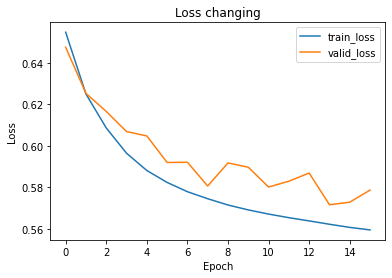

In [11]:
train_loss_idx = list(range(0, len(train_loss_history)))
valid_loss_idx = list(range(0, len(valid_loss_history)))

plt.plot(train_loss_idx, train_loss_history, label="train_loss")
plt.plot(valid_loss_idx, valid_loss_history, label="valid_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Loss changing")

plt.legend()
plt.show()

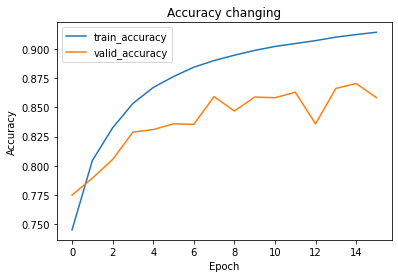

In [12]:
train_accuracy_idx = list(range(0, len(train_accuracy_history)))
valid_accuracy_idx = list(range(0, len(valid_accuracy_history)))

plt.plot(train_accuracy_idx, train_accuracy_history, label="train_accuracy")
plt.plot(valid_accuracy_idx, valid_accuracy_history, label="valid_accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("Accuracy changing")

plt.legend()
plt.show()